In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=24, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42733,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:55001,Total threads: 1
Dashboard: http://127.0.0.1:35393/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:38690,


In [4]:
from utils import Import_Expt_Front, date_fmt

In [5]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc').squeeze()

In [6]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [7]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']

In [8]:
dataset_gridT_1d = EXF.import_multipe_expt('grid_T',vars_of_interest=['rhop'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1})

In [9]:
dataset_gridW_1d = EXF.import_multipe_expt('grid_W',vars_of_interest=['bn2'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1})

In [10]:
f =1.432e-4

# Balanced richardson number ($Ri_{_b}$):
It is a measure of the horizontal buoyancy gradient against the vertical stratification, and as it approaches unity, or is smaller than 1, it can be used as a criterion to indicate that submesoscale may occur. It is calculated as:
\begin{equation}
Ri_{_b} = \frac{N^2f^2}{M^4}
\end{equation}

where f is the coriolis parameter. The horizontal buoyancy gradient ($M^2$) is then calculated as the sum of the horizontal gradiets.


Useful references
 - Liam Brannigan, David P. Marshall, Alberto Naveira-Garabato, A.J. George Nurser, The seasonal cycle of submesoscale flows, Ocean Modelling, Volume 92, 2015, Pages 69-84, ISSN 1463-5003
 - Thomas, L. N., Taylor, J. R., Ferrari, R., & Joyce, T. M. (2013). Symmetric instability in the Gulf Stream. Deep Sea Research Part II: Topical Studies in Oceanography, 91, 96-110

In [11]:
rho_0 = 1026
g = 9.81
b = -g *( dataset_gridT_1d.rhop_006 - rho_0 )/ rho_0

In [12]:
db_dx = b.diff("x")/grid.e1t.isel(x=slice(0,-1)).squeeze()

In [13]:
db_dy = b.isel(y=slice(1,-1)).diff("y")/grid.e2t.isel(y=slice(1,-2)).squeeze()

In [14]:
M4 =  ((db_dx.isel(y=slice(1,-2))**2 + db_dy.isel(x=slice(0,-1))**2)).rename("M4")


In [15]:
N2 = dataset_gridW_1d.bn2_006.isel(x=slice(0,-1),y=slice(1,-2)).transpose('depthw','time_counter','y','x')


In [16]:
def interp_field(x):
    x_centered = (x + x.roll(depthw=1))/2
    return x_centered.rename({"depthw":"deptht"})

In [17]:
N2_interp = interp_field(N2)

In [18]:
N2_interp['deptht'] = M4.deptht

In [19]:
Ri_b = ((N2_interp * f**2 )/ M4 ).rename("Ri_b")

In [20]:
counter=0
for time in Ri_b.sel(time_counter="0002").time_counter[counter:]:
    print(counter)
    Ri_b.sel(time_counter=time).expand_dims("time_counter").to_netcdf("./storage/balanced_RI_number_{0:03}.nc".format(counter))
    counter+=1

0


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


1


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


4


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


5


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


6


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


7


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
28

In [21]:
Ri_b = xr.open_mfdataset('./storage/balanced_RI_number*.nc',chunks={'time_counter':1})

In [22]:
Ri_b_a = np.arctan(-1/Ri_b)#.sel(time_counter="0002")

In [23]:
Ri_b_a_snapshot =  np.degrees(Ri_b_a.isel(time_counter=0).Ri_b)

In [24]:
# Ri_b.isel(time_counter=250).isel(x=400).Ri_b.plot(vmin=0,vmax=10)

Ri_b.where(Ri_b>1,0).where(Ri_b<10,0).isel(time_counter=0).max().compute()#.isel(x=400).Ri_b.plot(vmin=1,vmax=10)

<xarray.Dataset> Size: 24B
Dimensions:        ()
Coordinates:
    time_centered  object 8B 0002-01-01 12:00:00
    time_counter   object 8B 0002-01-01 12:00:00
Data variables:
    Ri_b           float64 8B 10.0

# Stability criteria

In [25]:
ζ = xr.open_dataset('./storage/geostrophic_vorticity.nc',chunks={'time_counter':1})

In [26]:
ζ

<xarray.Dataset> Size: 3GB
Dimensions:                        (y: 1200, x: 800, time_counter: 365)
Coordinates:
    nav_lat                        (y, x) float32 4MB dask.array<chunksize=(1200, 800), meta=np.ndarray>
    nav_lon                        (y, x) float32 4MB dask.array<chunksize=(1200, 800), meta=np.ndarray>
    time_centered                  (time_counter) object 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter                   (time_counter) object 3kB 0002-01-01 12:00...
Dimensions without coordinates: y, x
Data variables:
    __xarray_dataarray_variable__  (time_counter, y, x) float64 3GB dask.array<chunksize=(1, 1200, 800), meta=np.ndarray>

In [28]:
rossby = ζ/f

In [29]:
Ri_criteria = np.arctan(-(ζ+f)/f).isel(y=slice(1,-1)).__xarray_dataarray_variable__
ζ_f = (ζ*f).isel(y=slice(1,-1)).__xarray_dataarray_variable__

In [30]:
Ri_criteria_snapshot = np.degrees(Ri_criteria.where(ζ_f>0).isel(time_counter=250))

# Mask criteria

In [34]:
empty_array = xr.zeros_like(Ri_b_a_snapshot).drop_vars(("nav_lat","nav_lon"))

In [35]:
stability = empty_array.where(Ri_b_a_snapshot>Ri_criteria_snapshot,1,0).where(Ri_b_a_snapshot!=0,0).where(~np.isnan(Ri_criteria_snapshot),0)
stability_nm = empty_array.where(Ri_b_a_snapshot>Ri_criteria_snapshot,1,0)#.where(~np.isnan(Ri_criteria_snapshot),0)

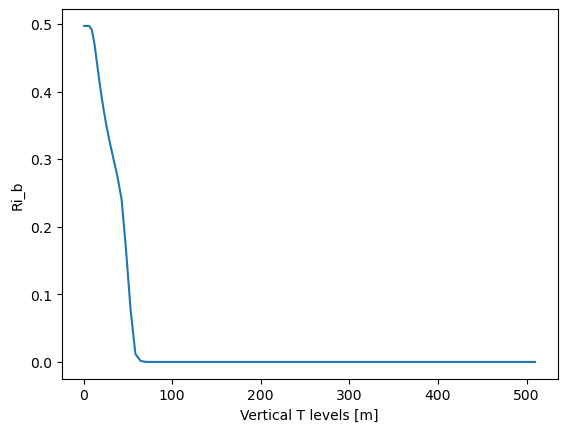

In [39]:
(stability.sum(('x','y'))/(1201*801)).plot()

In [41]:
time = 20
Ri_criteria_snapshot = np.degrees(Ri_criteria.where(ζ_f>0).isel(time_counter=time))
Ri_b_a_snapshot =  np.degrees(Ri_b_a.isel(time_counter=time))
empty_array = xr.zeros_like(Ri_b_a_snapshot).rename({"Ri_b":"Ri_stability"}).drop_vars(("nav_lat","nav_lon"))
stability = empty_array.where(Ri_b_a_snapshot.Ri_b>Ri_criteria_snapshot,1,0).where(Ri_b_a_snapshot.Ri_b!=0,0).where(~np.isnan(Ri_criteria_snapshot),0)
mean_stability = stability.mean(("x",'y')).Ri_stability

2025-07-31 21:55:22,497 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:55:32,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:55:41,854 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

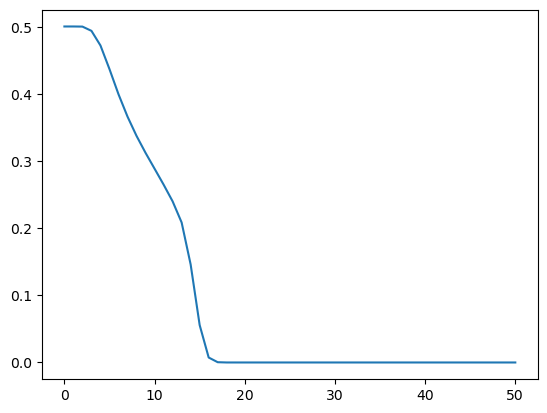

In [42]:
plt.plot(mean_stability)
# stability = empty_array.where(Ri_b_a_snapshot<Ri_criteria_snapshot,1,0).where(Ri_b_a_snapshot!=0,0).where(~np.isnan(Ri_criteria_snapshot),0)
# stability

In [46]:
Ri_b_a.Ri_b.shape

(365, 51, 1198, 800)

In [47]:
mean_stability = np.zeros((Ri_b_a.Ri_b.shape[0],Ri_b_a.Ri_b.shape[1]))
counter=0
for time in Ri_criteria.time_counter[:]:
    print(counter,time.values)
    Ri_criteria_snapshot = Ri_criteria.where(ζ_f>0).sel(time_counter=time).compute()
    Ri_b_a_snapshot =  Ri_b_a.where(Ri_b_a.Ri_b!=0,np.nan).sel(time_counter=time).compute()
    empty_array = xr.zeros_like(Ri_b_a_snapshot).rename({"Ri_b":"Ri_stability"}).drop_vars(("nav_lat","nav_lon"))
    stability = empty_array.where(Ri_b_a_snapshot.Ri_b>Ri_criteria_snapshot,1,0).where(Ri_b_a_snapshot.Ri_b!=0,0).where(~np.isnan(Ri_criteria_snapshot),0)
    mean_stability[counter,:] = stability.mean(("x",'y')).Ri_stability
    counter+=1

0 0002-01-01 12:00:00


2025-07-31 21:57:37,181 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:57:37,182 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 293.11 MiB -- Worker memory limit: 4.00 GiB


1 0002-01-02 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2 0002-01-03 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


3 0002-01-04 12:00:00


2025-07-31 21:58:16,185 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:58:16,359 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:58:16,466 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:58:16,643 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

4 0002-01-05 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 21:58:31,965 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:58:32,098 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB


5 0002-01-06 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 21:58:48,507 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:58:48,704 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB


6 0002-01-07 12:00:00


2025-07-31 21:59:04,111 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:59:04,369 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:59:04,644 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:59:04,833 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

7 0002-01-08 12:00:00


2025-07-31 21:59:19,827 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:59:20,144 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:59:20,282 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 313.79 MiB -- Worker memory limit: 4.00 GiB


8 0002-01-09 12:00:00
9 0002-01-10 12:00:00


2025-07-31 21:59:45,994 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:59:46,145 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 304.82 MiB -- Worker memory limit: 4.00 GiB


10 0002-01-11 12:00:00


2025-07-31 21:59:59,467 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 21:59:59,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.22 GiB -- Worker memory limit: 4.00 GiB


11 0002-01-12 12:00:00


2025-07-31 22:00:15,375 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.19 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:00:15,478 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB


12 0002-01-13 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 22:00:30,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.19 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:00:30,794 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB


13 0002-01-14 12:00:00


2025-07-31 22:00:45,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:00:46,183 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB


14 0002-01-15 12:00:00


2025-07-31 22:01:02,009 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:01:02,066 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB


15 0002-01-16 12:00:00


2025-07-31 22:01:15,017 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:01:15,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB


16 0002-01-17 12:00:00


2025-07-31 22:01:28,283 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.19 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:01:28,481 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:01:28,492 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:01:28,637 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

17 0002-01-18 12:00:00
18 0002-01-19 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 22:01:55,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:01:55,995 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB


19 0002-01-20 12:00:00


2025-07-31 22:02:12,288 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:02:12,420 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB


20 0002-01-21 12:00:00


2025-07-31 22:02:26,870 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:02:26,933 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.19 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:02:27,051 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:02:27,196 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

21 0002-01-22 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 22:02:42,376 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:02:42,404 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB


22 0002-01-23 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


23 0002-01-24 12:00:00
24 0002-01-25 12:00:00
25 0002-01-26 12:00:00


2025-07-31 22:03:35,518 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:03:35,567 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:03:35,947 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:03:36,087 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

26 0002-01-27 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 22:03:50,595 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:03:50,901 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:03:51,097 - distributed.worker.memory - WARNING - Worker is at 80% m

27 0002-01-28 12:00:00


2025-07-31 22:04:06,189 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:06,407 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.00 GiB


28 0002-01-29 12:00:00


2025-07-31 22:04:21,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:22,037 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:22,275 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:22,401 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

29 0002-01-30 12:00:00


2025-07-31 22:04:37,674 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:37,818 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 308.01 MiB -- Worker memory limit: 4.00 GiB


30 0002-01-31 12:00:00


2025-07-31 22:04:50,499 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:50,770 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:50,929 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 314.48 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:50,972 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:04:51,139 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 322.62 Mi

31 0002-02-01 12:00:00


2025-07-31 22:05:03,565 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:05:03,711 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 320.43 MiB -- Worker memory limit: 4.00 GiB


32 0002-02-02 12:00:00


2025-07-31 22:05:18,493 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:05:18,673 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB


33 0002-02-03 12:00:00


2025-07-31 22:05:49,358 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:05:49,449 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:05:50,060 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:05:50,067 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

34 0002-02-04 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 22:06:05,474 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:06:05,506 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:06:05,761 - distributed.worker.memory - WARNING - Worker is at 80% m

35 0002-02-05 12:00:00


2025-07-31 22:06:20,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:06:20,966 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:06:21,155 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:06:21,301 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

36 0002-02-06 12:00:00


2025-07-31 22:06:35,696 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:06:35,771 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB


37 0002-02-07 12:00:00


2025-07-31 22:06:48,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB


38 0002-02-08 12:00:00


2025-07-31 22:07:00,557 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:00,619 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:00,719 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 308.31 MiB -- Worker memory limit: 4.00 GiB


39 0002-02-09 12:00:00


2025-07-31 22:07:13,068 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:13,399 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:13,782 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:14,107 - distributed.worker.memory - WARNING - Worker is at 6% memory usage. Resuming worker. Process memor

40 0002-02-10 12:00:00


2025-07-31 22:07:27,574 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:27,928 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.00 GiB


41 0002-02-11 12:00:00


2025-07-31 22:07:43,322 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:43,360 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:43,562 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:43,675 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

42 0002-02-12 12:00:00


2025-07-31 22:07:59,138 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:59,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:59,563 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:07:59,718 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

43 0002-02-13 12:00:00


2025-07-31 22:08:15,098 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:15,154 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:15,795 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:16,252 - distributed.worker.memory - WARNING - Worker is at 6% memory usage. Resuming worker. Process memor

44 0002-02-14 12:00:00


2025-07-31 22:08:29,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:29,171 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:29,193 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:29,341 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

45 0002-02-15 12:00:00


2025-07-31 22:08:41,325 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:41,419 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:41,653 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:41,802 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

46 0002-02-16 12:00:00


2025-07-31 22:08:54,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:54,389 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:54,959 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:08:55,120 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

47 0002-02-17 12:00:00


2025-07-31 22:09:10,155 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:10,313 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB


48 0002-02-18 12:00:00


2025-07-31 22:09:24,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:24,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:25,260 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:25,421 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

49 0002-02-19 12:00:00


2025-07-31 22:09:40,335 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:40,494 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:40,750 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:40,889 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

50 0002-02-20 12:00:00


2025-07-31 22:09:55,481 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:55,548 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:55,867 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:09:55,998 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

51 0002-02-21 12:00:00


2025-07-31 22:10:08,421 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:10:08,658 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB


52 0002-02-22 12:00:00


2025-07-31 22:10:20,775 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:10:21,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:10:21,409 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:10:21,622 - distributed.worker.memory - WARNING - Worker is at 6% memory usage. Resuming worker. Process memor

53 0002-02-23 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 22:10:33,768 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:10:33,970 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:10:34,263 - distributed.worker.memory - WARNING - Worker is at 80% m

54 0002-02-24 12:00:00
55 0002-02-25 12:00:00


2025-07-31 22:11:04,132 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:04,149 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:04,554 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:04,661 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

56 0002-02-26 12:00:00


2025-07-31 22:11:19,422 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:19,700 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:19,967 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:20,147 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

57 0002-02-27 12:00:00


2025-07-31 22:11:35,489 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:35,519 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:35,970 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:36,160 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

58 0002-02-28 12:00:00


2025-07-31 22:11:49,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:11:50,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB


59 0002-03-01 12:00:00


2025-07-31 22:12:01,913 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:12:02,063 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB


60 0002-03-02 12:00:00


2025-07-31 22:12:14,288 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:12:14,441 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:12:14,566 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:12:14,707 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

61 0002-03-03 12:00:00


2025-07-31 22:12:26,227 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:12:26,298 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB


62 0002-03-04 12:00:00


2025-07-31 22:12:38,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:12:38,074 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB


63 0002-03-05 12:00:00


2025-07-31 22:12:50,153 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:12:50,352 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB


64 0002-03-06 12:00:00


2025-07-31 22:13:01,728 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:01,939 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:01,984 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:02,141 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

65 0002-03-07 12:00:00


2025-07-31 22:13:14,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:15,071 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:15,096 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:15,214 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 331.29 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:15,288 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 332.03 Mi

66 0002-03-08 12:00:00


2025-07-31 22:13:26,863 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.95 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:27,333 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:27,373 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:27,547 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

67 0002-03-09 12:00:00


2025-07-31 22:13:39,161 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:39,171 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:39,359 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:39,495 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

68 0002-03-10 12:00:00


2025-07-31 22:13:51,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:51,406 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:13:51,544 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 314.50 MiB -- Worker memory limit: 4.00 GiB


69 0002-03-11 12:00:00


2025-07-31 22:14:03,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:03,439 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB


70 0002-03-12 12:00:00


/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2025-07-31 22:14:16,020 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:16,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:16,364 - distributed.worker.memory - WARNING - Worker is at 80% m

71 0002-03-13 12:00:00


2025-07-31 22:14:28,439 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:28,713 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB


72 0002-03-14 12:00:00


2025-07-31 22:14:41,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:41,491 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.00 GiB


73 0002-03-15 12:00:00


2025-07-31 22:14:53,575 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:53,762 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:53,784 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:14:53,792 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

74 0002-03-16 12:00:00


2025-07-31 22:15:05,537 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:05,751 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:05,971 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:06,119 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

75 0002-03-17 12:00:00


2025-07-31 22:15:18,787 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:18,982 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:19,145 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:19,294 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

76 0002-03-18 12:00:00


2025-07-31 22:15:31,021 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:31,272 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:31,286 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:31,466 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

77 0002-03-19 12:00:00


2025-07-31 22:15:43,613 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:43,759 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:43,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:43,917 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

78 0002-03-20 12:00:00


2025-07-31 22:15:56,909 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:56,955 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:57,077 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:15:57,251 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

79 0002-03-21 12:00:00


2025-07-31 22:16:08,975 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:09,133 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 317.88 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:09,200 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:09,365 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:09,591 - distributed.worker.memory - WARNING - Worker is at 6% memory usage. Resuming worker. Process memory: 272.55 Mi

80 0002-03-22 12:00:00


2025-07-31 22:16:21,894 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:21,985 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:22,067 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:22,223 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

81 0002-03-23 12:00:00


2025-07-31 22:16:33,889 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:34,055 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:34,081 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:34,163 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

82 0002-03-24 12:00:00


2025-07-31 22:16:45,404 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:45,566 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:45,695 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 329.30 MiB -- Worker memory limit: 4.00 GiB


83 0002-03-25 12:00:00


2025-07-31 22:16:57,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:57,277 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:57,311 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:16:57,434 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

84 0002-03-26 12:00:00


2025-07-31 22:17:09,569 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:09,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:09,967 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:10,118 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

85 0002-03-27 12:00:00


2025-07-31 22:17:21,761 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:21,861 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:21,966 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:22,069 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

86 0002-03-28 12:00:00


2025-07-31 22:17:33,731 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:33,862 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:34,005 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memory: 322.73 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:34,218 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged mem

87 0002-03-29 12:00:00


2025-07-31 22:17:45,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:45,829 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB


88 0002-03-30 12:00:00


2025-07-31 22:17:57,732 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:57,843 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:57,986 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:17:58,131 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

89 0002-03-31 12:00:00


2025-07-31 22:18:09,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:09,838 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:10,080 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:10,246 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

90 0002-04-01 12:00:00


2025-07-31 22:18:21,242 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:21,438 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:21,479 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:21,621 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

91 0002-04-02 12:00:00


2025-07-31 22:18:33,833 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:33,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB


92 0002-04-03 12:00:00


2025-07-31 22:18:45,354 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:45,508 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:45,604 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:45,783 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

93 0002-04-04 12:00:00


2025-07-31 22:18:57,600 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:18:57,827 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB


94 0002-04-05 12:00:00


2025-07-31 22:19:10,066 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:10,125 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB


95 0002-04-06 12:00:00


2025-07-31 22:19:21,718 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:21,954 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB


96 0002-04-07 12:00:00


2025-07-31 22:19:34,127 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:34,376 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:34,433 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:34,515 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

97 0002-04-08 12:00:00


2025-07-31 22:19:46,334 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:46,471 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:46,568 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:19:46,672 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

98 0002-04-09 12:00:00


2025-07-31 22:19:59,959 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:00,016 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB


99 0002-04-10 12:00:00


2025-07-31 22:20:11,679 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:12,035 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:12,264 - distributed.worker.memory - WARNING - Worker is at 6% memory usage. Resuming worker. Process memory: 281.68 MiB -- Worker memory limit: 4.00 GiB


100 0002-04-11 12:00:00


2025-07-31 22:20:24,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:24,208 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:24,289 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:24,431 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

101 0002-04-12 12:00:00


2025-07-31 22:20:36,022 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:36,212 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:36,264 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:36,444 - distributed.worker.memory - WARNING - Worker is at 7% memory usage. Resuming worker. Process memor

102 0002-04-13 12:00:00


2025-07-31 22:20:48,925 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:49,056 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:49,186 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:20:49,275 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

103 0002-04-14 12:00:00


2025-07-31 22:21:01,118 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:01,168 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:01,467 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:01,575 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

104 0002-04-15 12:00:00


2025-07-31 22:21:13,801 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:14,077 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:14,255 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 331.79 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:14,501 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged mem

105 0002-04-16 12:00:00


2025-07-31 22:21:26,508 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:26,731 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:27,877 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:27,883 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

106 0002-04-17 12:00:00


2025-07-31 22:21:56,868 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.90 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:56,880 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.91 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:58,477 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:21:58,662 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

107 0002-04-18 12:00:00


2025-07-31 22:22:10,079 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:10,429 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:10,783 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:10,871 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

108 0002-04-19 12:00:00


2025-07-31 22:22:22,489 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:22,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:22,976 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:23,036 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

109 0002-04-20 12:00:00


2025-07-31 22:22:34,914 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:34,977 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:35,271 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:35,452 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

110 0002-04-21 12:00:00


2025-07-31 22:22:46,640 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:46,995 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:47,065 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:47,264 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

111 0002-04-22 12:00:00


2025-07-31 22:22:59,536 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:22:59,755 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB


112 0002-04-23 12:00:00


2025-07-31 22:23:11,686 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:11,724 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB


113 0002-04-24 12:00:00


2025-07-31 22:23:23,836 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:23,947 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:24,177 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:24,288 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

114 0002-04-25 12:00:00


2025-07-31 22:23:36,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:36,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:36,678 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:36,905 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

115 0002-04-26 12:00:00


2025-07-31 22:23:48,379 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:48,393 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:48,681 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:23:48,686 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

116 0002-04-27 12:00:00


2025-07-31 22:24:00,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:00,248 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB


117 0002-04-28 12:00:00


2025-07-31 22:24:12,438 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:12,645 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:12,780 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:12,958 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

118 0002-04-29 12:00:00


2025-07-31 22:24:24,745 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:24,861 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:25,277 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:25,447 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

119 0002-04-30 12:00:00


2025-07-31 22:24:36,752 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:36,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:37,371 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:37,522 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

120 0002-05-01 12:00:00


2025-07-31 22:24:48,556 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:24:48,649 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB


121 0002-05-02 12:00:00


2025-07-31 22:25:00,139 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:00,339 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:00,669 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:00,854 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

122 0002-05-03 12:00:00


2025-07-31 22:25:12,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:12,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:13,501 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:13,729 - distributed.worker.memory - WARNING - Worker is at 6% memory usage. Resuming worker. Process memor

123 0002-05-04 12:00:00


2025-07-31 22:25:24,680 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:24,876 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:25,158 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:25,322 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

124 0002-05-05 12:00:00


2025-07-31 22:25:37,363 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:37,471 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:37,692 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:37,877 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

125 0002-05-06 12:00:00


2025-07-31 22:25:49,436 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:49,554 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:49,770 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:25:49,929 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

126 0002-05-07 12:00:00


2025-07-31 22:26:01,749 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:01,939 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:02,088 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:02,275 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

127 0002-05-08 12:00:00


2025-07-31 22:26:14,059 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:14,160 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:14,374 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:14,540 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

128 0002-05-09 12:00:00


2025-07-31 22:26:26,845 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:27,045 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:27,183 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:27,328 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

129 0002-05-10 12:00:00


2025-07-31 22:26:42,149 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:42,239 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:42,487 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:42,644 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

130 0002-05-11 12:00:00


2025-07-31 22:26:59,961 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:26:59,962 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:00,282 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:00,445 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

131 0002-05-12 12:00:00


2025-07-31 22:27:11,965 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:11,978 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:12,273 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:12,435 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

132 0002-05-13 12:00:00


2025-07-31 22:27:24,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:24,248 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:24,378 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:24,577 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

133 0002-05-14 12:00:00


2025-07-31 22:27:36,447 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:36,539 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:36,779 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:36,985 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

134 0002-05-15 12:00:00


2025-07-31 22:27:49,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:49,362 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:49,371 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:27:49,516 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

135 0002-05-16 12:00:00


2025-07-31 22:28:01,407 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:01,683 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:01,816 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:01,828 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 338.85 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:01,873 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 343.32 Mi

136 0002-05-17 12:00:00


2025-07-31 22:28:14,663 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:14,745 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:14,992 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:15,195 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

137 0002-05-18 12:00:00


2025-07-31 22:28:27,145 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:27,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:27,481 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:27,592 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

138 0002-05-19 12:00:00


2025-07-31 22:28:39,551 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:39,632 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:39,883 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:40,100 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

139 0002-05-20 12:00:00


2025-07-31 22:28:52,476 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:52,499 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:52,780 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:28:52,944 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

140 0002-05-21 12:00:00


2025-07-31 22:29:04,457 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:04,785 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:04,976 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 340.39 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:05,108 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged mem

141 0002-05-22 12:00:00


2025-07-31 22:29:16,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:16,944 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:17,322 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:17,381 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

142 0002-05-23 12:00:00


2025-07-31 22:29:28,944 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:28,957 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:29,278 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:29,387 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

143 0002-05-24 12:00:00


2025-07-31 22:29:41,262 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:41,393 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:41,684 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:41,785 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

144 0002-05-25 12:00:00


2025-07-31 22:29:53,601 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:53,681 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:53,887 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:29:54,108 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

145 0002-05-26 12:00:00


2025-07-31 22:30:05,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:05,757 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:05,977 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:06,075 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

146 0002-05-27 12:00:00


2025-07-31 22:30:17,865 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:18,030 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:18,371 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:18,557 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

147 0002-05-28 12:00:00


2025-07-31 22:30:30,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:30,232 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:30,396 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:30,564 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

148 0002-05-29 12:00:00


2025-07-31 22:30:41,794 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:41,992 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:42,095 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:42,298 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

149 0002-05-30 12:00:00


2025-07-31 22:30:54,447 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:54,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:55,083 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:30:55,222 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

150 0002-05-31 12:00:00


2025-07-31 22:31:07,165 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:07,267 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:07,494 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:07,579 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

151 0002-06-01 12:00:00


2025-07-31 22:31:19,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:19,272 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:19,476 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:19,614 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

152 0002-06-02 12:00:00


2025-07-31 22:31:31,805 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:31,948 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:32,187 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:32,282 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

153 0002-06-03 12:00:00


2025-07-31 22:31:43,765 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:43,983 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:44,274 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:44,418 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

154 0002-06-04 12:00:00


2025-07-31 22:31:56,563 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:56,648 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:56,891 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:31:56,987 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

155 0002-06-05 12:00:00


2025-07-31 22:32:09,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:09,149 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:09,485 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:09,487 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

156 0002-06-06 12:00:00


2025-07-31 22:32:21,568 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:21,689 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:21,983 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:22,016 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

157 0002-06-07 12:00:00


2025-07-31 22:32:34,662 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:34,834 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:34,978 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:35,080 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

158 0002-06-08 12:00:00


2025-07-31 22:32:47,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:32:47,409 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB


159 0002-06-09 12:00:00


2025-07-31 22:33:00,168 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:00,360 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:00,587 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:00,784 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

160 0002-06-10 12:00:00


2025-07-31 22:33:13,057 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:13,262 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:13,589 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:13,661 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

161 0002-06-11 12:00:00


2025-07-31 22:33:28,037 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:28,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:28,381 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:28,539 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

162 0002-06-12 12:00:00


2025-07-31 22:33:40,633 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:40,985 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:41,162 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 348.75 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:41,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged mem

163 0002-06-13 12:00:00


2025-07-31 22:33:53,356 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:33:53,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB


164 0002-06-14 12:00:00


2025-07-31 22:34:06,267 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:06,341 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:06,585 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:06,675 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

165 0002-06-15 12:00:00


2025-07-31 22:34:19,277 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:19,512 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:19,688 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:19,844 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

166 0002-06-16 12:00:00


2025-07-31 22:34:32,459 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:32,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:32,883 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:32,892 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

167 0002-06-17 12:00:00


2025-07-31 22:34:44,858 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:44,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:45,388 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:34:45,416 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

168 0002-06-18 12:00:00


2025-07-31 22:35:04,835 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:04,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:05,185 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:05,285 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

169 0002-06-19 12:00:00


2025-07-31 22:35:17,735 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:17,830 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:18,080 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:18,176 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

170 0002-06-20 12:00:00


2025-07-31 22:35:30,066 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:30,143 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:30,471 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:30,649 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

171 0002-06-21 12:00:00


2025-07-31 22:35:42,052 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:42,244 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:42,567 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:42,756 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

172 0002-06-22 12:00:00


2025-07-31 22:35:54,446 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:54,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:54,796 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:35:54,997 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

173 0002-06-23 12:00:00


2025-07-31 22:36:06,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:06,870 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:07,074 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:07,219 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

174 0002-06-24 12:00:00


2025-07-31 22:36:18,962 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:19,169 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:19,297 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:19,477 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

175 0002-06-25 12:00:00


2025-07-31 22:36:35,619 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.92 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:35,622 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.94 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:36,376 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:36,481 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

176 0002-06-26 12:00:00


2025-07-31 22:36:52,842 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:52,939 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:53,485 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:36:53,582 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

177 0002-06-27 12:00:00


2025-07-31 22:37:07,242 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:07,340 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:07,688 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:07,783 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

178 0002-06-28 12:00:00


2025-07-31 22:37:22,408 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:22,588 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:23,087 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:23,282 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

179 0002-06-29 12:00:00


2025-07-31 22:37:36,050 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:36,143 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:36,374 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:36,649 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

180 0002-06-30 12:00:00


2025-07-31 22:37:48,538 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:48,744 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:48,881 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:37:49,074 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

181 0002-07-01 12:00:00


2025-07-31 22:38:01,834 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:02,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:02,574 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:02,771 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

182 0002-07-02 12:00:00


2025-07-31 22:38:19,834 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.93 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:19,839 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:20,578 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:20,760 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

183 0002-07-03 12:00:00


2025-07-31 22:38:36,339 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:36,555 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:36,986 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:37,087 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

184 0002-07-04 12:00:00


2025-07-31 22:38:50,452 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:50,662 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:51,000 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:38:51,163 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

185 0002-07-05 12:00:00


2025-07-31 22:39:05,236 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:05,440 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.95 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:05,980 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:06,090 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

186 0002-07-06 12:00:00


2025-07-31 22:39:18,153 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:18,217 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:18,384 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:18,610 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

187 0002-07-07 12:00:00


2025-07-31 22:39:29,940 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:30,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:30,287 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:30,393 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

188 0002-07-08 12:00:00


2025-07-31 22:39:42,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:43,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:43,387 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:43,573 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

189 0002-07-09 12:00:00


2025-07-31 22:39:58,635 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:58,638 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:59,286 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:39:59,288 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

190 0002-07-10 12:00:00


2025-07-31 22:40:13,029 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:13,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:13,583 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:13,587 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

191 0002-07-11 12:00:00


2025-07-31 22:40:27,052 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:27,138 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:27,788 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:27,891 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

192 0002-07-12 12:00:00


2025-07-31 22:40:42,362 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:42,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:42,785 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:42,888 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

193 0002-07-13 12:00:00


2025-07-31 22:40:54,832 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:54,842 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:55,181 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:40:55,377 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

194 0002-07-14 12:00:00


2025-07-31 22:41:07,194 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:07,500 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:07,694 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:07,865 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

195 0002-07-15 12:00:00


2025-07-31 22:41:19,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:19,645 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:20,000 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:20,069 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

196 0002-07-16 12:00:00


2025-07-31 22:41:34,537 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:34,631 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:35,193 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:35,281 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

197 0002-07-17 12:00:00


2025-07-31 22:41:49,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:49,779 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:50,276 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:41:50,397 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

198 0002-07-18 12:00:00


2025-07-31 22:42:05,240 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:05,254 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:05,880 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:05,894 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

199 0002-07-19 12:00:00


2025-07-31 22:42:19,843 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:20,050 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:20,478 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:20,579 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

200 0002-07-20 12:00:00


2025-07-31 22:42:33,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:34,068 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB


201 0002-07-21 12:00:00


2025-07-31 22:42:46,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:46,178 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:46,480 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:46,634 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

202 0002-07-22 12:00:00


2025-07-31 22:42:58,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:58,769 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:59,091 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:42:59,283 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

203 0002-07-23 12:00:00


2025-07-31 22:43:15,606 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:15,629 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:16,091 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:16,181 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

204 0002-07-24 12:00:00


2025-07-31 22:43:32,782 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.95 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:33,239 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:33,677 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:33,912 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

205 0002-07-25 12:00:00


2025-07-31 22:43:50,805 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:50,876 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:51,481 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:43:51,584 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

206 0002-07-26 12:00:00


2025-07-31 22:44:08,862 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:09,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:09,776 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:09,784 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

207 0002-07-27 12:00:00


2025-07-31 22:44:25,403 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:25,610 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:26,087 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:26,091 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

208 0002-07-28 12:00:00


2025-07-31 22:44:38,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:38,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:38,706 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:38,809 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

209 0002-07-29 12:00:00


2025-07-31 22:44:54,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:54,125 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:54,695 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:44:54,783 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

210 0002-07-30 12:00:00


2025-07-31 22:45:09,475 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:09,648 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:09,984 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:10,168 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

211 0002-07-31 12:00:00


2025-07-31 22:45:23,693 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:23,890 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:24,192 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:24,194 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

212 0002-08-01 12:00:00


2025-07-31 22:45:37,662 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:37,667 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:38,188 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:38,274 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

213 0002-08-02 12:00:00


2025-07-31 22:45:53,013 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:53,097 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:53,146 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 354.37 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:45:53,342 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 354.30 MiB -- Worker memory limit: 4.00 GiB


214 0002-08-03 12:00:00


2025-07-31 22:46:05,632 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:05,783 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 347.64 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:05,934 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:06,067 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 352.93 MiB -- Worker memory limit: 4.00 GiB


215 0002-08-04 12:00:00


2025-07-31 22:46:17,576 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:17,892 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:18,040 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:18,077 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 353.03 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:18,239 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 352.18 Mi

216 0002-08-05 12:00:00


2025-07-31 22:46:29,705 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:30,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:30,187 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:30,413 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

217 0002-08-06 12:00:00


2025-07-31 22:46:44,095 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:44,212 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:44,580 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:44,676 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

218 0002-08-07 12:00:00


2025-07-31 22:46:59,094 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:59,302 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:59,592 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:46:59,771 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

219 0002-08-08 12:00:00


2025-07-31 22:47:13,581 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:13,716 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:14,097 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:14,174 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

220 0002-08-09 12:00:00


2025-07-31 22:47:27,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:28,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:28,594 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:28,779 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

221 0002-08-10 12:00:00


2025-07-31 22:47:42,105 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:42,217 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:42,483 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:42,503 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

222 0002-08-11 12:00:00


2025-07-31 22:47:54,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:54,774 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:54,892 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:47:54,978 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

223 0002-08-12 12:00:00


2025-07-31 22:48:07,618 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:07,718 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:07,982 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:08,080 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

224 0002-08-13 12:00:00


2025-07-31 22:48:20,981 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:21,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:21,489 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:21,586 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

225 0002-08-14 12:00:00


2025-07-31 22:48:42,082 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.82 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:42,402 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.84 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:45,390 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:48:45,391 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

226 0002-08-15 12:00:00


2025-07-31 22:49:16,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:16,690 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:17,286 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:17,295 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

227 0002-08-16 12:00:00


2025-07-31 22:49:29,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:29,944 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:30,193 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:30,283 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

228 0002-08-17 12:00:00


2025-07-31 22:49:42,433 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:42,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:42,884 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:42,892 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

229 0002-08-18 12:00:00


2025-07-31 22:49:56,272 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:56,358 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:56,781 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:49:56,886 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

230 0002-08-19 12:00:00


2025-07-31 22:50:10,834 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:11,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:11,578 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:11,583 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

231 0002-08-20 12:00:00


2025-07-31 22:50:25,728 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:25,936 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:26,386 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:26,492 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

232 0002-08-21 12:00:00


2025-07-31 22:50:42,061 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.94 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:42,236 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:42,901 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:42,993 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

233 0002-08-22 12:00:00


2025-07-31 22:50:56,548 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:56,654 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:56,982 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:50:57,095 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

234 0002-08-23 12:00:00


2025-07-31 22:51:08,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:09,029 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:09,284 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:09,475 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

235 0002-08-24 12:00:00


2025-07-31 22:51:22,258 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:22,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:22,789 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:22,892 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

236 0002-08-25 12:00:00


2025-07-31 22:51:36,751 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:36,758 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:37,282 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:37,291 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

237 0002-08-26 12:00:00


2025-07-31 22:51:51,563 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:51,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:52,088 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:51:52,343 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

238 0002-08-27 12:00:00


2025-07-31 22:52:06,143 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:06,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:06,787 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:06,791 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

239 0002-08-28 12:00:00


2025-07-31 22:52:20,839 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:21,043 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.95 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:21,489 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:21,691 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

240 0002-08-29 12:00:00


2025-07-31 22:52:34,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:34,169 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:34,388 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:34,489 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

241 0002-08-30 12:00:00


2025-07-31 22:52:46,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:46,540 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:46,885 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:46,980 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

242 0002-08-31 12:00:00


2025-07-31 22:52:58,743 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:58,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:59,096 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:52:59,265 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

243 0002-09-01 12:00:00


2025-07-31 22:53:11,854 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:11,933 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:12,200 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:12,430 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

244 0002-09-02 12:00:00


2025-07-31 22:53:23,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:24,047 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:24,394 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:24,483 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

245 0002-09-03 12:00:00


2025-07-31 22:53:36,562 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:36,678 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:36,882 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:37,095 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

246 0002-09-04 12:00:00


2025-07-31 22:53:49,262 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:49,344 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:49,681 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:53:49,694 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

247 0002-09-05 12:00:00


2025-07-31 22:54:01,343 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:01,545 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:01,682 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:01,868 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

248 0002-09-06 12:00:00


2025-07-31 22:54:13,835 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:14,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:14,291 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:14,478 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

249 0002-09-07 12:00:00


2025-07-31 22:54:26,744 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:26,845 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:27,189 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:27,287 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

250 0002-09-08 12:00:00


2025-07-31 22:54:39,278 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:39,380 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:39,690 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:39,697 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

251 0002-09-09 12:00:00


2025-07-31 22:54:51,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:51,833 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:51,993 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:54:52,207 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

252 0002-09-10 12:00:00


2025-07-31 22:55:03,732 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:04,079 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:04,181 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:04,388 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

253 0002-09-11 12:00:00


2025-07-31 22:55:16,136 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:16,334 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:16,486 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:16,683 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

254 0002-09-12 12:00:00


2025-07-31 22:55:28,530 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:28,742 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:28,983 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:29,078 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

255 0002-09-13 12:00:00


2025-07-31 22:55:40,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:41,087 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:41,300 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 359.02 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:41,310 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:41,481 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 356.68 Mi

256 0002-09-14 12:00:00


2025-07-31 22:55:53,157 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:53,213 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:53,399 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:53,433 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 357.19 MiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:55:53,609 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memory: 359.68 Mi

257 0002-09-15 12:00:00


2025-07-31 22:56:05,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:05,757 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:05,985 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:06,091 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

258 0002-09-16 12:00:00


2025-07-31 22:56:17,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:17,852 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:17,984 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:18,174 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

259 0002-09-17 12:00:00


2025-07-31 22:56:29,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:29,843 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:29,992 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:30,189 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

260 0002-09-18 12:00:00


2025-07-31 22:56:41,760 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:41,782 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:42,084 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:42,091 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

261 0002-09-19 12:00:00


2025-07-31 22:56:54,188 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:54,390 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:54,418 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:56:54,490 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

262 0002-09-20 12:00:00


2025-07-31 22:57:06,102 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:06,302 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:06,386 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:06,559 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

263 0002-09-21 12:00:00


2025-07-31 22:57:18,790 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:18,970 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:19,194 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:19,290 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

264 0002-09-22 12:00:00


2025-07-31 22:57:31,001 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:31,124 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:31,392 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:31,514 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

265 0002-09-23 12:00:00


2025-07-31 22:57:43,553 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:43,663 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:43,884 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:43,982 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

266 0002-09-24 12:00:00


2025-07-31 22:57:56,152 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:56,287 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:56,498 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:57:56,681 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

267 0002-09-25 12:00:00


2025-07-31 22:58:08,844 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:09,031 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:09,198 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:09,439 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

268 0002-09-26 12:00:00


2025-07-31 22:58:20,966 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:21,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:21,295 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:21,355 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

269 0002-09-27 12:00:00


2025-07-31 22:58:33,463 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:33,597 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:33,815 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:33,982 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

270 0002-09-28 12:00:00


2025-07-31 22:58:45,961 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:46,131 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:46,293 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:46,477 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

271 0002-09-29 12:00:00


2025-07-31 22:58:58,532 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:58,647 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:58,978 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:58:59,191 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

272 0002-09-30 12:00:00


2025-07-31 22:59:11,397 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:11,641 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:11,694 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:11,866 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

273 0002-10-01 12:00:00


2025-07-31 22:59:23,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:23,839 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:24,094 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:24,190 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

274 0002-10-02 12:00:00


2025-07-31 22:59:36,469 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:36,576 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:36,797 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:36,887 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

275 0002-10-03 12:00:00


2025-07-31 22:59:48,359 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:48,543 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:48,694 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 22:59:48,884 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

276 0002-10-04 12:00:00


2025-07-31 23:00:01,155 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:01,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:01,486 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:01,493 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

277 0002-10-05 12:00:00


2025-07-31 23:00:13,151 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:13,360 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:13,586 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:13,682 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

278 0002-10-06 12:00:00


2025-07-31 23:00:25,641 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:25,835 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:25,981 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:26,177 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

279 0002-10-07 12:00:00


2025-07-31 23:00:37,771 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:37,951 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:38,192 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:38,293 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

280 0002-10-08 12:00:00


2025-07-31 23:00:50,368 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:50,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:50,803 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:00:50,895 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

281 0002-10-09 12:00:00


2025-07-31 23:01:02,734 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:02,838 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:03,085 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:03,192 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

282 0002-10-10 12:00:00


2025-07-31 23:01:15,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:15,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:15,786 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:16,010 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

283 0002-10-11 12:00:00


2025-07-31 23:01:27,365 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:27,434 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:27,693 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:27,781 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

284 0002-10-12 12:00:00


2025-07-31 23:01:40,150 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:40,376 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:40,493 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:40,553 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

285 0002-10-13 12:00:00


2025-07-31 23:01:53,343 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:53,440 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:53,690 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:01:53,886 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

286 0002-10-14 12:00:00


2025-07-31 23:02:05,838 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:06,034 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:06,219 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:06,389 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

287 0002-10-15 12:00:00


2025-07-31 23:02:18,267 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:18,342 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:18,694 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:18,794 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

288 0002-10-16 12:00:00


2025-07-31 23:02:30,858 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:30,964 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.92 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:31,390 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:31,493 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

289 0002-10-17 12:00:00


2025-07-31 23:02:43,283 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:43,366 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:43,786 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:43,979 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

290 0002-10-18 12:00:00


2025-07-31 23:02:55,876 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:56,034 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:56,298 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:02:56,433 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

291 0002-10-19 12:00:00


2025-07-31 23:03:08,248 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:08,433 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:08,598 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:08,843 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

292 0002-10-20 12:00:00


2025-07-31 23:03:20,149 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:20,598 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:20,746 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:20,750 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

293 0002-10-21 12:00:00


2025-07-31 23:03:32,740 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:32,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:33,181 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:33,300 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

294 0002-10-22 12:00:00


2025-07-31 23:03:45,240 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:45,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:45,597 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:45,682 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

295 0002-10-23 12:00:00


2025-07-31 23:03:57,589 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:57,882 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:57,983 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:03:58,011 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

296 0002-10-24 12:00:00


2025-07-31 23:04:09,464 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:09,789 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:09,899 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:10,050 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

297 0002-10-25 12:00:00


2025-07-31 23:04:22,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:22,573 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:22,791 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:23,024 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

298 0002-10-26 12:00:00


2025-07-31 23:04:34,363 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:34,532 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.94 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:34,898 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:35,086 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

299 0002-10-27 12:00:00


2025-07-31 23:04:47,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:47,162 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:47,398 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:47,485 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

300 0002-10-28 12:00:00


2025-07-31 23:04:59,166 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:59,364 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:59,482 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:04:59,689 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

301 0002-10-29 12:00:00


2025-07-31 23:05:11,547 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:11,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:11,884 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:12,117 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

302 0002-10-30 12:00:00


2025-07-31 23:05:23,635 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:23,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:24,079 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:24,249 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

303 0002-10-31 12:00:00


2025-07-31 23:05:36,341 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:36,542 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:36,718 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:36,896 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

304 0002-11-01 12:00:00


2025-07-31 23:05:48,383 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:48,596 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:48,704 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:05:48,898 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

305 0002-11-02 12:00:00


2025-07-31 23:06:02,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:02,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:02,487 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:02,593 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

306 0002-11-03 12:00:00


2025-07-31 23:06:14,387 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:14,546 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:14,784 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:14,943 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

307 0002-11-04 12:00:00


2025-07-31 23:06:26,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:26,956 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:27,191 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:27,194 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

308 0002-11-05 12:00:00


2025-07-31 23:06:38,788 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:39,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:39,165 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:39,191 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

309 0002-11-06 12:00:00


2025-07-31 23:06:51,037 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:51,237 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:51,392 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:06:51,608 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

310 0002-11-07 12:00:00


2025-07-31 23:07:02,841 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:03,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:03,188 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:03,382 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

311 0002-11-08 12:00:00


2025-07-31 23:07:15,442 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:15,550 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:15,795 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:15,991 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

312 0002-11-09 12:00:00


2025-07-31 23:07:27,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:27,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:27,991 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:28,189 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

313 0002-11-10 12:00:00


2025-07-31 23:07:40,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:40,292 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:40,486 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:40,581 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

314 0002-11-11 12:00:00


2025-07-31 23:07:52,444 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:52,531 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:52,801 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:07:52,883 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

315 0002-11-12 12:00:00


2025-07-31 23:08:04,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:05,218 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:05,400 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:05,558 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

316 0002-11-13 12:00:00


2025-07-31 23:08:16,760 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:16,951 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:17,093 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:17,327 - distributed.worker.memory - WARNING - Worker is at 9% memory usage. Resuming worker. Process memor

317 0002-11-14 12:00:00


2025-07-31 23:08:29,839 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:29,948 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:30,183 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:30,364 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

318 0002-11-15 12:00:00


2025-07-31 23:08:41,650 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:41,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:41,997 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:42,178 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

319 0002-11-16 12:00:00


2025-07-31 23:08:53,681 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:53,880 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:53,985 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:08:54,137 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

320 0002-11-17 12:00:00


2025-07-31 23:09:05,850 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:05,947 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:06,192 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:06,378 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

321 0002-11-18 12:00:00


2025-07-31 23:09:17,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:17,682 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:17,992 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:17,994 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

322 0002-11-19 12:00:00


2025-07-31 23:09:30,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:30,245 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:30,462 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:30,499 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

323 0002-11-20 12:00:00


2025-07-31 23:09:42,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:42,367 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:42,508 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:42,684 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

324 0002-11-21 12:00:00


2025-07-31 23:09:54,646 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:54,875 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:55,085 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:09:55,190 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

325 0002-11-22 12:00:00


2025-07-31 23:10:06,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:06,635 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:06,787 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.27 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:06,919 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

326 0002-11-23 12:00:00


2025-07-31 23:10:18,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:19,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:19,281 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:19,384 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

327 0002-11-24 12:00:00


2025-07-31 23:10:30,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:31,142 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:31,189 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:31,372 - distributed.worker.memory - WARNING - Worker is at 9% memory usage. Resuming worker. Process memor

328 0002-11-25 12:00:00


2025-07-31 23:10:44,238 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:44,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:44,504 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:44,694 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

329 0002-11-26 12:00:00


2025-07-31 23:10:57,100 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:10:57,563 - distributed.worker.memory - WARNING - Worker is at 9% memory usage. Resuming worker. Process memory: 374.13 MiB -- Worker memory limit: 4.00 GiB


330 0002-11-27 12:00:00


2025-07-31 23:11:09,154 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:09,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:09,486 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:09,676 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

331 0002-11-28 12:00:00


2025-07-31 23:11:21,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:21,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:21,393 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:21,571 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

332 0002-11-29 12:00:00


2025-07-31 23:11:33,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:33,943 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:34,193 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:34,278 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

333 0002-11-30 12:00:00


2025-07-31 23:11:45,861 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:46,081 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:46,291 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:46,392 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

334 0002-12-01 12:00:00


2025-07-31 23:11:58,152 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:58,281 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:58,487 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:11:58,589 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

335 0002-12-02 12:00:00


2025-07-31 23:12:10,542 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:10,753 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:10,993 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:11,185 - distributed.worker.memory - WARNING - Worker is at 9% memory usage. Resuming worker. Process memor

336 0002-12-03 12:00:00


2025-07-31 23:12:24,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:24,584 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:24,695 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:24,862 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

337 0002-12-04 12:00:00


2025-07-31 23:12:36,751 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:36,967 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:37,185 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:37,280 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

338 0002-12-05 12:00:00


2025-07-31 23:12:49,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:49,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:50,050 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:12:50,181 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

339 0002-12-06 12:00:00


2025-07-31 23:13:02,764 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:02,850 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:03,003 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:03,174 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

340 0002-12-07 12:00:00


2025-07-31 23:13:15,350 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:15,542 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:15,697 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:15,925 - distributed.worker.memory - WARNING - Worker is at 9% memory usage. Resuming worker. Process memor

341 0002-12-08 12:00:00


2025-07-31 23:13:27,254 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:27,463 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:27,709 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:27,902 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

342 0002-12-09 12:00:00


2025-07-31 23:13:39,860 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:40,195 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:40,249 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:40,425 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

343 0002-12-10 12:00:00


2025-07-31 23:13:53,338 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:53,474 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:53,686 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:13:53,786 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

344 0002-12-11 12:00:00


2025-07-31 23:14:06,925 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.91 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:07,125 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.91 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:08,689 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:09,088 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

345 0002-12-12 12:00:00


2025-07-31 23:14:39,224 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.88 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:39,332 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.92 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:40,692 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:40,694 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

346 0002-12-13 12:00:00


2025-07-31 23:14:52,672 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:52,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:53,098 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:14:53,189 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

347 0002-12-14 12:00:00


2025-07-31 23:15:05,660 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:05,740 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:06,096 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:06,185 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

348 0002-12-15 12:00:00


2025-07-31 23:15:18,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.08 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:18,363 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:18,582 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:18,693 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

349 0002-12-16 12:00:00


2025-07-31 23:15:30,137 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:30,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:30,485 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:30,591 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

350 0002-12-17 12:00:00


2025-07-31 23:15:42,644 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:42,846 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:43,080 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:43,186 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

351 0002-12-18 12:00:00


2025-07-31 23:15:54,745 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:55,057 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:55,188 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:15:55,398 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

352 0002-12-19 12:00:00


2025-07-31 23:16:06,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:06,942 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:07,207 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:07,398 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

353 0002-12-20 12:00:00


2025-07-31 23:16:20,830 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.96 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:21,132 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.94 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:21,581 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:21,866 - distributed.worker.memory - WARNING - Worker is at 9% memory usage. Resuming worker. Process memor

354 0002-12-21 12:00:00


2025-07-31 23:16:36,740 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:36,836 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:37,261 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:37,286 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

355 0002-12-22 12:00:00


2025-07-31 23:16:51,360 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:51,429 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.09 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:51,794 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:16:51,894 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

356 0002-12-23 12:00:00


2025-07-31 23:17:05,543 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:05,629 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:06,187 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:06,196 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

357 0002-12-24 12:00:00


2025-07-31 23:17:19,640 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:19,736 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:20,295 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:20,393 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

358 0002-12-25 12:00:00


2025-07-31 23:17:31,960 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:32,050 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:32,392 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:32,394 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

359 0002-12-26 12:00:00


2025-07-31 23:17:44,045 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:44,156 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.05 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:44,395 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.22 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:44,594 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

360 0002-12-27 12:00:00


2025-07-31 23:17:56,348 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:56,535 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.97 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:56,888 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:17:57,172 - distributed.worker.memory - WARNING - Worker is at 8% memory usage. Resuming worker. Process memor

361 0002-12-28 12:00:00


2025-07-31 23:18:10,847 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:10,930 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:11,385 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:11,581 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

362 0002-12-29 12:00:00


2025-07-31 23:18:25,538 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:25,743 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.99 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:26,195 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:26,385 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memo

363 0002-12-30 12:00:00


2025-07-31 23:18:41,156 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.04 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:41,353 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:41,698 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.24 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:41,765 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

364 0002-12-31 12:00:00


2025-07-31 23:18:55,471 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.03 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:55,527 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.98 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:55,998 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:18:56,088 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

In [49]:
baroclinic_instability = Ri_b.where(Ri_b>1,0).where(Ri_b<10,0)
mean_baroclinic_instability = baroclinic_instability.where(baroclinic_instability<1,1).mean(("x",'y')).compute()

2025-07-31 23:21:42,564 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:21:43,265 - distributed.worker.memory - WARNING - Worker is at 34% memory usage. Resuming worker. Process memory: 1.38 GiB -- Worker memory limit: 4.00 GiB


2025-07-31 23:32:39,018 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.49 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:33:31,589 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.45 GiB -- Worker memory limit: 4.00 GiB
2025-07-31 23:33:45,554 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

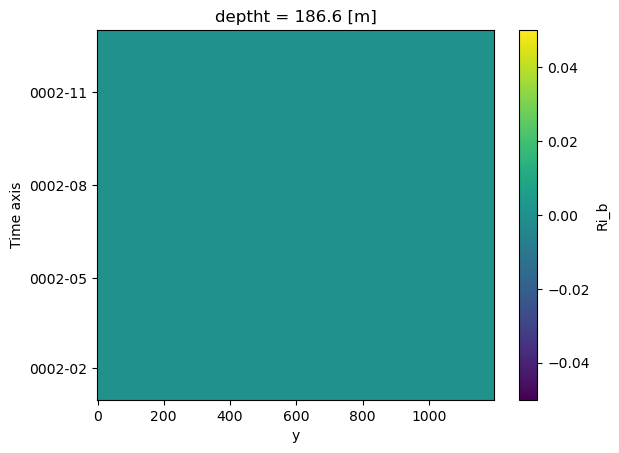

In [51]:
baroclinic_instability.isel(deptht=30,x=400).Ri_b.plot()

In [54]:
mean_baroclinic_instability.to_netcdf("./storage/baroclinic_instability_fixed.nc")

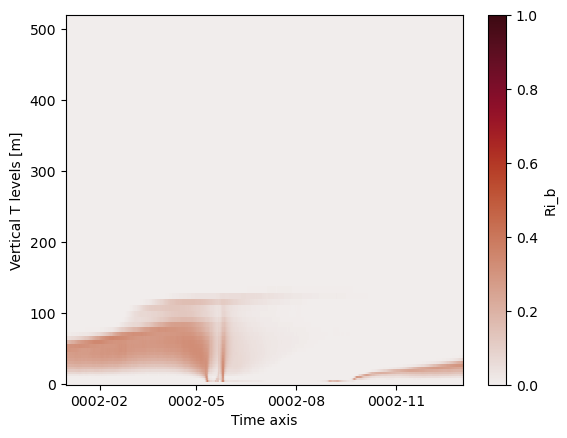

In [55]:
mean_baroclinic_instability.Ri_b.plot(x='time_counter',cmap=cm.cm.amp,vmin=0,vmax=1)

In [57]:
stability_data = xr.ones_like(Ri_b_a.mean(("x",'y')))

In [59]:
stability_data['Ri_b'] = (("time_counter","deptht"),mean_stability)


In [60]:
stability_data = stability_data.rename({"Ri_b":"Percent_Ri_b"})

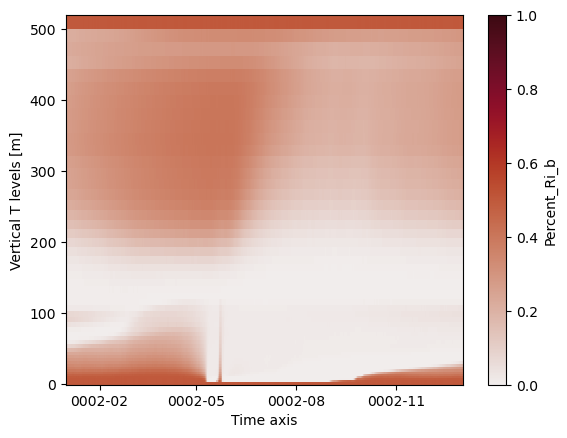

In [61]:
stability_data.Percent_Ri_b.plot(x='time_counter',cmap=cm.cm.amp,vmin=0,vmax=1)


In [62]:
stability_data.to_netcdf("./storage/Percent_Ri_b_fixed.nc")

In [64]:
stability_data = xr.open_dataset("./storage/Percent_Ri_b_fixed.nc")